## Getting Own Data in PyTorch with Custom Datasets

In [2]:
import torch
from torch import nn
print(torch.__version__+"\n")

device = "cuda" if torch.cuda.is_available else "cpu"
!nvidia-smi
device

2.2.0+cu121

Sun Mar  3 23:05:09 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 551.61                 Driver Version: 551.61         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3050 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   29C    P0             11W /   95W |       0MiB /   4096MiB |      0%      Default |
|                                         |                        |                  N/A |
+----------------------------------

'cuda'

### 1. Get Data Food101

In [3]:
import requests
import zipfile
from pathlib import Path

data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)
    
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...") 
        zip_ref.extractall(image_path)

data\pizza_steak_sushi directory exists.


In [4]:
import os
def walk_through_data(dir_path):
    """Walks through dir_path returning its contents"""
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} Directories and {len(filenames)} images in '{dirpath}'.")
walk_through_data(dir_path=image_path)

There are 2 Directories and 0 images in 'data\pizza_steak_sushi'.
There are 3 Directories and 0 images in 'data\pizza_steak_sushi\test'.
There are 0 Directories and 25 images in 'data\pizza_steak_sushi\test\pizza'.
There are 0 Directories and 19 images in 'data\pizza_steak_sushi\test\steak'.
There are 0 Directories and 31 images in 'data\pizza_steak_sushi\test\sushi'.
There are 3 Directories and 0 images in 'data\pizza_steak_sushi\train'.
There are 0 Directories and 78 images in 'data\pizza_steak_sushi\train\pizza'.
There are 0 Directories and 75 images in 'data\pizza_steak_sushi\train\steak'.
There are 0 Directories and 72 images in 'data\pizza_steak_sushi\train\sushi'.


In [5]:
# setup train test path
train_dir = image_path/"train"
test_dir = image_path/"test"

train_dir, test_dir

(WindowsPath('data/pizza_steak_sushi/train'),
 WindowsPath('data/pizza_steak_sushi/test'))

In [6]:
image_path

WindowsPath('data/pizza_steak_sushi')

### Visualize Image

data\pizza_steak_sushi\test\sushi\2394442.jpg
sushi
Random Image Path: data\pizza_steak_sushi\test\sushi\2394442.jpg
image class: sushi
image height: 408
image width: 512


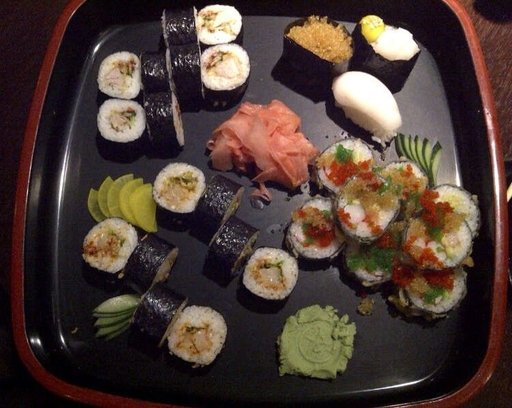

In [7]:
import random
from PIL import Image

random.seed(42)
image_path_list = list(image_path.glob("*/*/*.jpg"))

random_image_path = random.choice(image_path_list)
print(random_image_path)

image_class = random_image_path.parent.stem
print(image_class)

img = Image.open(random_image_path)

print(f"Random Image Path: {random_image_path}")
print(f"image class: {image_class}")
print(f"image height: {img.height}")
print(f"image width: {img.width}")
img

(-0.5, 511.5, 407.5, -0.5)

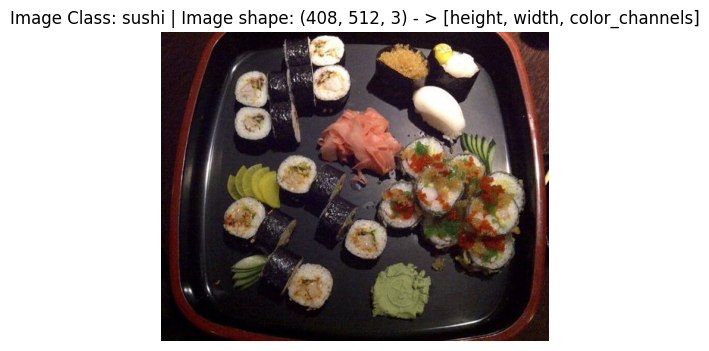

In [8]:
import numpy as np
import matplotlib.pyplot as plt

img_np = np.asarray(img)

plt.figure(figsize=(5,5))
plt.imshow(img_np)
plt.title(f"Image Class: {image_class} | Image shape: {img_np.shape} - > [height, width, color_channels]") # HWC
plt.axis(False)

In [9]:
## Transforming data
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
])

# transform(img).shape # CHW torch.Size([3, 64, 64])

c:\Users\dagam\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


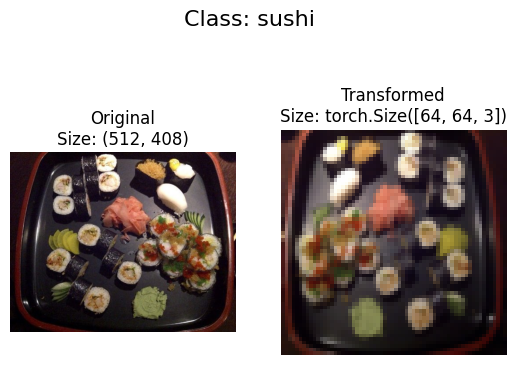

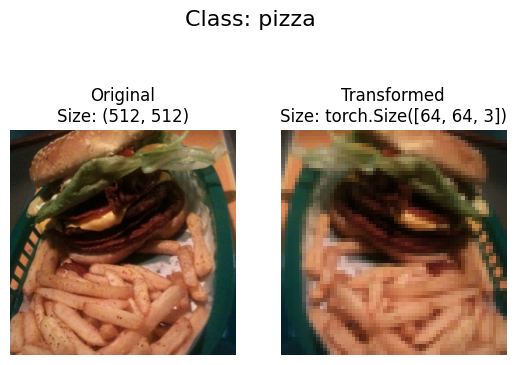

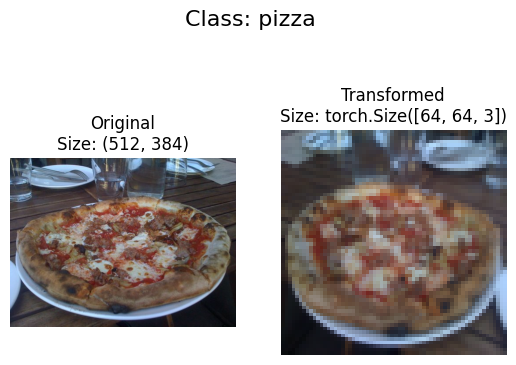

In [10]:
def plot_transformed_images(image_paths, transform, n=3, seed=42):
    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(nrows=1, ncols=2)
            ax[0].imshow(f)
            ax[0].set_title(f"Original\nSize: {f.size}")
            ax[0].axis(False)

            transformed_image = transform(f).permute(1, 2, 0) # change CHW -> HWC (setting axes locations)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed\nSize: {transformed_image.shape}")
            ax[1].axis(False)

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_path_list, transform)

In [11]:
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=transform,
                                  target_transform=None)

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=transform,
                                 target_transform=None)

print(train_data, test_data)

Dataset ImageFolder
    Number of datapoints: 225
    Root location: data\pizza_steak_sushi\train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           ) Dataset ImageFolder
    Number of datapoints: 75
    Root location: data\pizza_steak_sushi\test
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )


In [12]:
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [13]:
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [14]:
len(train_data), len(test_data)

(225, 75)

In [18]:
train_data.samples[0]

('data\\pizza_steak_sushi\\train\\pizza\\1008844.jpg', 0)

In [27]:
img, label = train_data[0][0], train_data[0][1]
class_names[label]
# print(f"Image Tensor:\n {img}")
print(f"Image Shape:\n {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image Label: {label}")
print(f"Label Datatype: {type(label)}")

Image Shape:
 torch.Size([3, 64, 64])
Image datatype: torch.float32
Image Label: 0
Label Datatype: <class 'int'>


Original Shape: torch.Size([3, 64, 64]) -> [channel, height, width]
Image Permute: torch.Size([64, 64, 3]) -> [height, width, channel]


Text(0.5, 1.0, 'pizza')

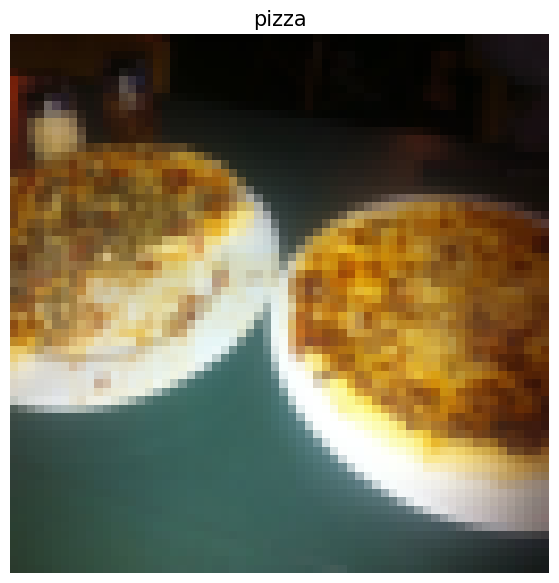

In [28]:
img_permute = img.permute(1,2,0) # plt takes channel at end

print(f"Original Shape: {img.shape} -> [channel, height, width]")
print(f"Image Permute: {img_permute.shape} -> [height, width, channel]")

plt.figure(figsize=(10,7))
plt.imshow(img_permute)
plt.axis("off")
plt.title(class_names[label], fontsize=15)

In [29]:
train_loader = DataLoader(train_data, shuffle=True, batch_size=32)
test_loader = DataLoader(test_data, shuffle=True, batch_size=32)